In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import splitfolders
import os
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
splitfolders.ratio(r"C:\Users\Sathwik\Plant Disease classification\potato", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

In [2]:
train_path = r"C:\Users\Sathwik\Plant Disease classification\output\train"
val_path = r"C:\Users\Sathwik\Plant Disease classification\output\val"
test_path = r"C:\Users\Sathwik\Plant Disease classification\output\test"

In [ ]:
LABELS = os.listdir(train_path)

imagedatagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        )

for label in LABELS:
    imagedatagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
    
    augm = imagedatagen.flow_from_directory(train_path,
                                     save_to_dir=train_path+"\\"+label,
                                     target_size=(256, 256),
                                     classes=[label],
                                     batch_size=7000)
    for i in range(len(augm)*5):
        batch = next(augm) 

In [3]:
import tensorflow_datasets as tfds
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_path,
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Found 10326 files belonging to 3 classes.
Found 215 files belonging to 3 classes.
Found 216 files belonging to 3 classes.


In [25]:
Input_shape=(256,256,3)
model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=Input_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5", 
                                monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")

In [26]:
history = model.fit(train_ds , epochs=24, 
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/24
323/323 [==============================] - 90s 275ms/step - loss: 0.5090 - accuracy: 0.7597 - val_loss: 0.2472 - val_accuracy: 0.8977

Epoch 00001: saving model to weights.01-0.25.hdf5
Epoch 2/24
323/323 [==============================] - 92s 285ms/step - loss: 0.2237 - accuracy: 0.9101 - val_loss: 0.2090 - val_accuracy: 0.9256

Epoch 00002: saving model to weights.02-0.21.hdf5
Epoch 3/24
323/323 [==============================] - 89s 277ms/step - loss: 0.1524 - accuracy: 0.9389 - val_loss: 0.2506 - val_accuracy: 0.9395

Epoch 00003: saving model to weights.03-0.25.hdf5
Epoch 4/24
323/323 [==============================] - 92s 285ms/step - loss: 0.1240 - accuracy: 0.9525 - val_loss: 0.1802 - val_accuracy: 0.9395

Epoch 00004: saving model to weights.04-0.18.hdf5
Epoch 5/24
323/323 [==============================] - 90s 279ms/step - loss: 0.0972 - accuracy: 0.9601 - val_loss: 0.1494 - val_accuracy: 0.9628

Epoch 00005: saving model to weights.05-0.15.hdf5
Epoch 6/24
323/323 [

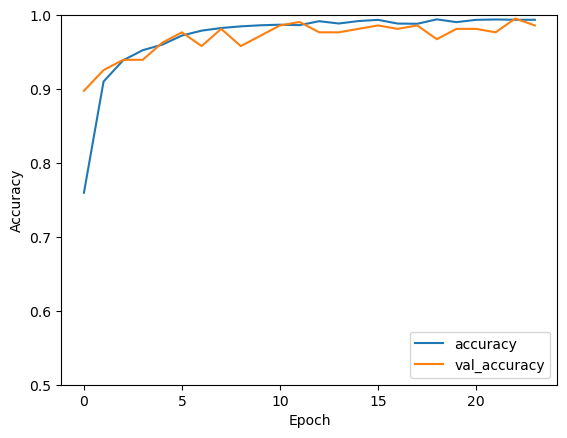

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

#evalu = model.evaluate(test, verbose=1)

In [28]:
evalu = model.evaluate(test_ds, verbose=1)

7/7 [==============================] - 1s 59ms/step - loss: 0.0829 - accuracy: 0.9861


In [29]:
new_model = tf.keras.models.load_model('weights.23-0.02.hdf5')

In [30]:
new_model.evaluate(test_ds, verbose=1)

7/7 [==============================] - 1s 62ms/step - loss: 0.0689 - accuracy: 0.9907


[0.0688868835568428, 0.9907407164573669]